CS524: Introduction to Optimization Lecture 18
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## October 21, 2019
--------------

The following visualization uses **geopandas** to visualize the map of USA and look up the longtitude and latitude of every city in this problem. Extracting the "tour" variable from GAMS, we can show the routing result in the map.

### Visualize flight routes by geopandas

In [1]:
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

# load the world map and extract the map of United States of America
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
us = world[(world.pop_est>0) & (world.name=="United States of America")]

# create a dictionary to map city names to their geological information
city = dict()
city['Atlanta']      = [ -84.387985, 33.748997]
city['Chicago']      = [ -87.629799, 41.878113]
city['Denver']       = [-104.990250, 39.739235]
city['Houston']      = [ -95.369804, 29.760427]
city['LosAngeles']   = [-118.243683, 34.052235]
city['Madison']      = [ -89.401230, 43.073051]
city['NewYork']      = [ -74.005974, 40.712776]
city['SanFrancisco'] = [-122.419418, 37.774929]
city['Seattle']      = [-122.332069, 47.606209]
city['WashingtonDC'] = [ -77.036873, 38.907192]
city['Miami']        = [ -80.191788, 25.761681]

# the main function to visualize routes
def plot_with_tour(tour):
    tour.columns = ['from','to']
    us.plot(figsize=(20,20),color='white', edgecolor='black')
    for k, v in city.items():
        plt.scatter(*v, c='black',alpha=0.5)
        plt.text(*v, k)
    for index, row in tour.iterrows():
        st = city[row['from']]
        ed = city[row['to']] 
        plt.plot([st[0],ed[0]], [st[1],ed[1]], 'r-')
    plt.xlim(-130,-60)
    plt.ylim(23,53)

In [2]:
%reload_ext gams_magic

In [3]:
%gams_cleanup -k
%gams_reset

### TSP example

This is an 11 city example

In [4]:
%%gams
set city /  Atlanta,Chicago,Denver,Houston,LosAngeles,Madison,Miami,NewYork,SanFrancisco,Seattle,WashingtonDC /;
alias(city,i,j,k);

table      dist(i,j)      "distances"
            Atlanta Chicago   Denver Houston LosAngeles Madison Miami NewYork SanFrancisco Seattle WashingtonDC
Atlanta      0       587     1212    701       1936       700    604     748      2139       2182     543
Chicago      587      0      920     940       1745       122   1188     713      1858       1737     597
Denver       1212     920     0      879        831       839   1726    1631       949       1021    1494
Houston      701     940     879      0        1372       978    968    1420      1645       1891    1220
LosAngeles   1936    1745    831     1374        0        1670  2339    2451       347        959    2300
Madison      700     122     839      978      1670        0    1303     808       1764      1618     706
Miami        604    1188    1726     968       2339       1303    0      1092      2594       2734    923
NewYork      748     713    1631     1420      2451        808  1092     0        2571       2408    205
SanFrancisco 2139   1858    949     1645       347        1764  2594    2571        0         678    2442
Seattle      2182    1737   1021    1891       959        1618  2734    2408       678         0     2329
WashingtonDC  543    597    1494    1220      2300         706   923      205      2442        2329    0 ;

binary variables x(i,j);
free variable obj;

equations defobj, assign1(j), assign2(i);

defobj..
obj =e= sum((i,j), dist(i,j) * x(i,j));

assign1(j)..
sum(i$(not sameas(i,j)), x(i,j)) =e= 1;

assign2(i)..
sum(j$(not sameas(i,j)), x(i,j)) =e= 1;

x.fx(i,i) = 0;

set tour(i,i) ;
* Just print the tour in a simple way
option tour:0:0:1 ;

model tsp /defobj, assign1, assign2/;
solve tsp using mip min obj;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;
display tour;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),5604.0,23,111,MIP,CPLEX,0.013


,city,city
0,Atlanta,Miami
1,Chicago,Madison
2,Denver,Houston
3,Houston,Denver
4,LosAngeles,Seattle
5,Madison,Chicago
6,Miami,Atlanta
7,NewYork,WashingtonDC
8,SanFrancisco,LosAngeles
9,Seattle,SanFrancisco


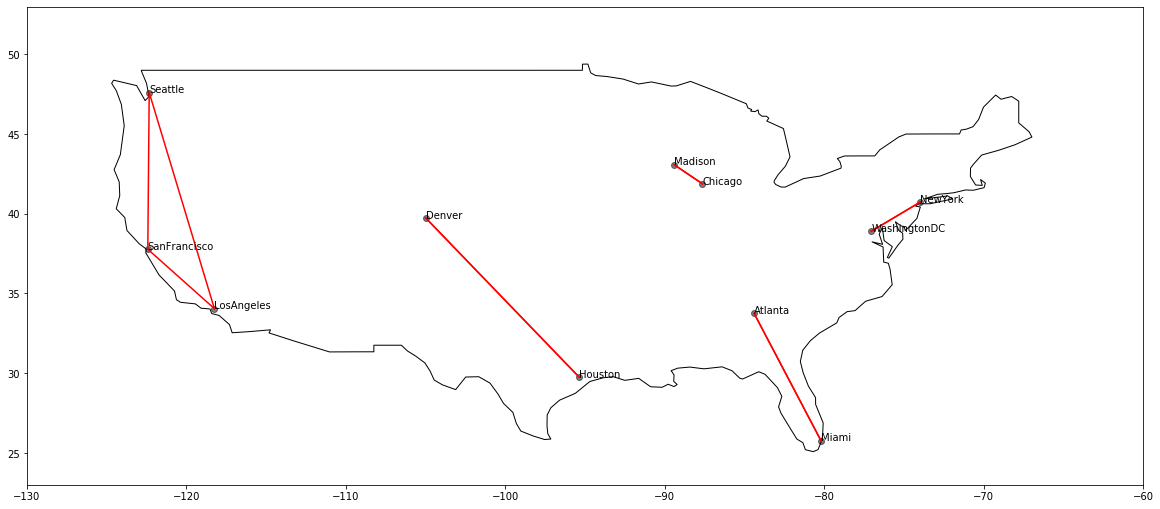

In [5]:
%gams_pull -d tour
display(tour)

plot_with_tour(tour)

Simple loop elimination

In [6]:
%%gams
equations simpleloop(i,j);

simpleloop(i,j)$(not sameas(i,j))..
  x(i,j) + x(j,i) =L= 1;

tour(i,j) = no ;
model tsp2 /defobj, assign1, assign2, simpleloop /;
solve tsp2 using mip minimizing obj ;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;
display tour;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),6857.0,133,111,MIP,CPLEX,0.018


,city,city
0,Atlanta,Miami
1,Chicago,NewYork
2,Denver,Madison
3,Houston,Denver
4,LosAngeles,SanFrancisco
5,Madison,Chicago
6,Miami,Houston
7,NewYork,WashingtonDC
8,SanFrancisco,Seattle
9,Seattle,LosAngeles


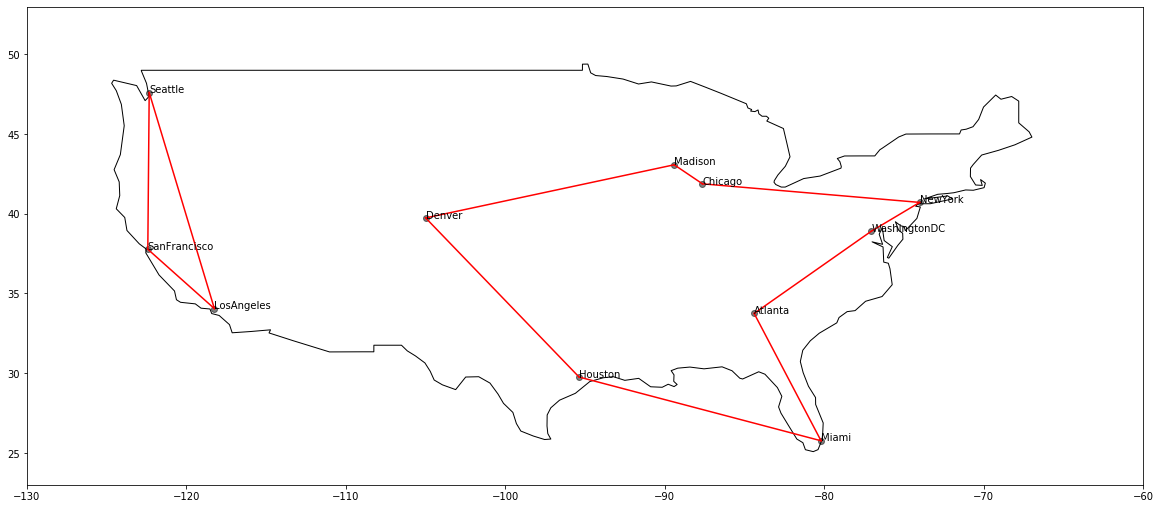

In [7]:
%gams_pull -d tour
display(tour)
plot_with_tour(tour)

Add triangles

In [8]:
%%gams
equations triangle(i,j,k);

triangle(i,j,k)..
  x(i,j) + x(i,k) + x(j,k) + x(j,i) + x(k,i) + x(k,j) =L= 2 ;

tour(i,j) = no ;
model tsp3 /defobj, assign1, assign2, simpleloop, triangle /;
solve tsp3 using mip minimizing obj ;
display obj.l;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;
display tour;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),7010.0,1464,122,MIP,CPLEX,0.023


,city,city
0,Atlanta,Miami
1,Chicago,NewYork
2,Denver,Seattle
3,Houston,Madison
4,LosAngeles,Denver
5,Madison,Chicago
6,Miami,Houston
7,NewYork,WashingtonDC
8,SanFrancisco,LosAngeles
9,Seattle,SanFrancisco


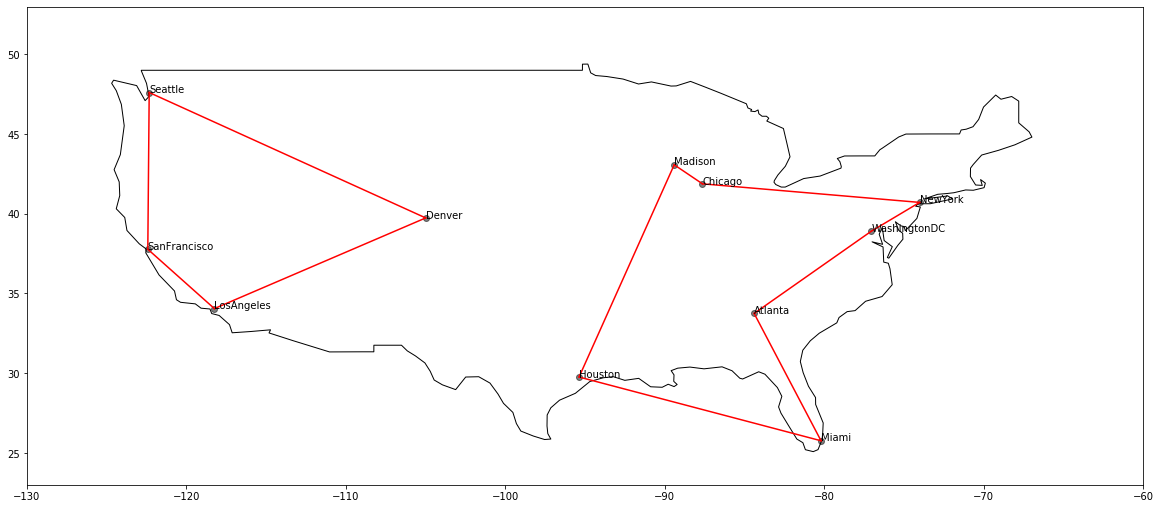

In [9]:
%gams_pull -d tour
display(tour)
plot_with_tour(tour)

Add subtour elimination constraints (See Pataki Teaching IP paper in SIAM)

In [10]:
%%gams
positive variables u(i) ;
equations mtz(i,j);

mtz(i,j)$(ord(i) ne 1 and ord(j) ne 1)..
  u(i) - u(j) + 1 =L= (card(i) - 1) * (1 - x(i,j)) ;

model tsp4 /defobj, assign1, assign2, mtz/;

u.lo(i) = 2; u.up(i) = card(i);
u.fx(i)$(i.ord eq 1) = 1;

option optcr = 0;

solve tsp4 using mip minimizing obj ;
display obj.l;
tour(i,j) = no;
tour(i,j)$(x.l(i,j) > 0.01) = yes ;
display tour;
display u.L;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),7412.0,123,131,MIP,CPLEX,0.057


,city,city
0,Atlanta,Miami
1,Chicago,NewYork
2,Denver,Madison
3,Houston,LosAngeles
4,LosAngeles,SanFrancisco
5,Madison,Chicago
6,Miami,Houston
7,NewYork,WashingtonDC
8,SanFrancisco,Seattle
9,Seattle,Denver


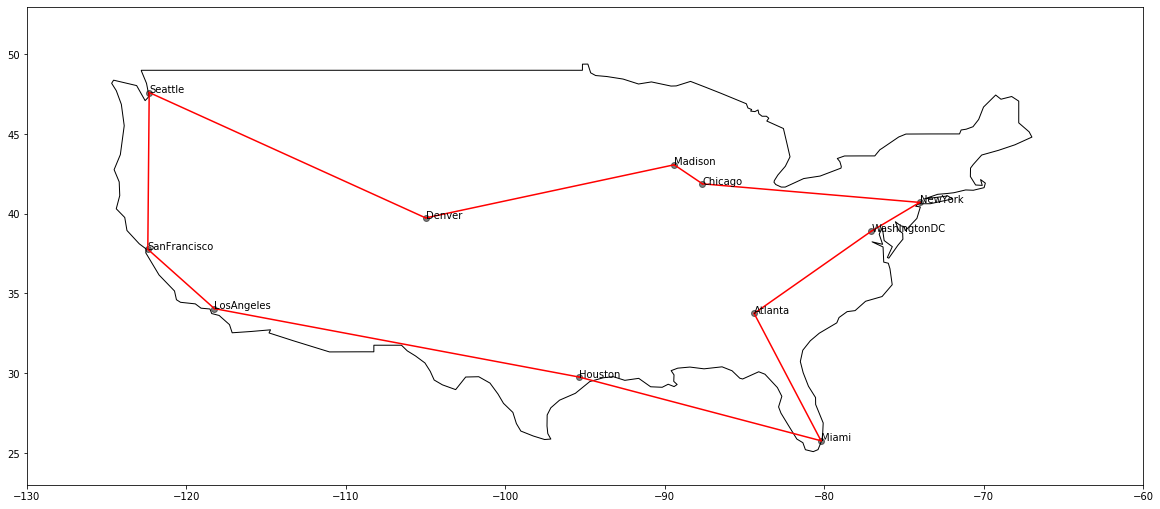

In [11]:
%gams_pull -d tour
display(tour)
plot_with_tour(tour)